In [7]:
from src.algorithms.alternating_least_squares import AlternatingLeastSquares
from src.helpers.dataset_indexer import DatasetIndexer
from src.helpers.checkpoint_manager import CheckpointManager
from src.recommenders import CollaborativeFilteringRecommenderBuilder
from src.backends import Backend
from src.helpers._logging import logger  # noqa
from src.settings import settings

from src.helpers.graphing import (
    plot_als_train_test_loss_evolution,
    plot_als_train_test_rmse_evolution,
    plot_error_evolution,
    plot_power_low_distribution,
    plot_data_item_distribution_as_hist,
)

In [8]:
dataset_indexer = DatasetIndexer(
    file_path="./ml-32m/ratings.csv",
    user_header="userId",
    item_header="movieId",
    rating_header="rating",
    limit=settings.general.LINES_COUNT_TO_READ,
)

indexed_data = dataset_indexer.index(
    approximate_train_ratio=settings.general.APPROXIMATE_TRAIN_RATIO
)

2025-01-05 16:50:16,531 [WARNING] The current implementation does not split the data into train and test sets exactly with the provided ratio. We use the provided ratio as a probability for a Bernoulli distribution to know whether the data point should be used as a training data or a test data.
2025-01-05 16:50:23,146 [WARNING] The limit of lines (.i.e 1000000) to index has been reached. Exiting without loading the rest... 
2025-01-05 16:50:23,147 [INFO] Successfully indexed 1000000 lines from ./ml-32m/ratings.csv


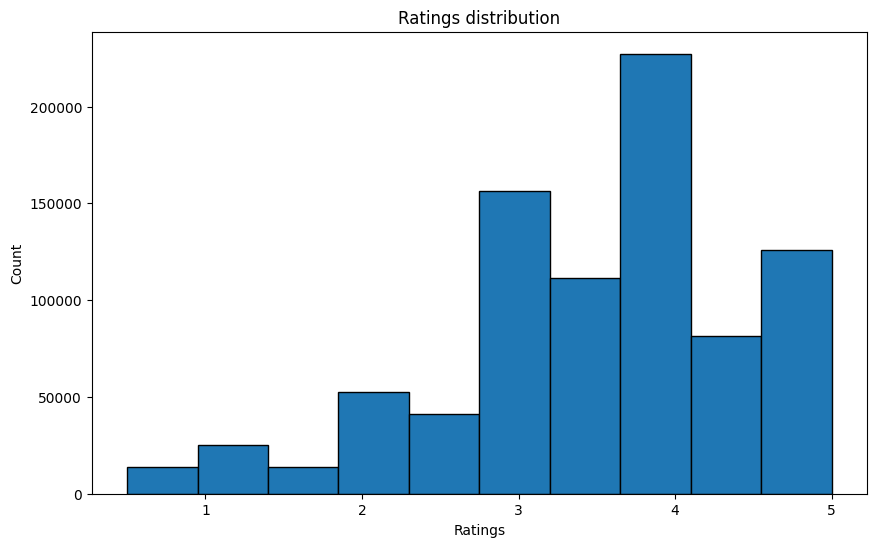

In [9]:
plot_data_item_distribution_as_hist(indexed_data)

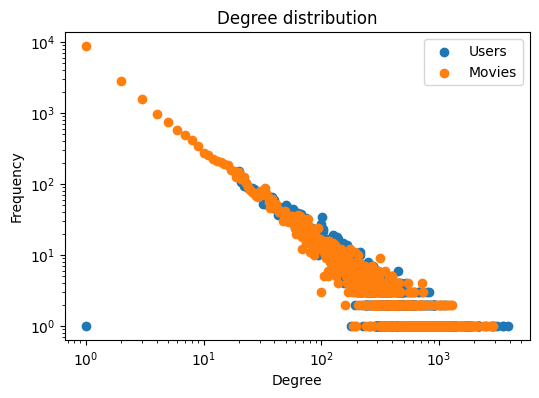

In [10]:
plot_power_low_distribution(
    indexed_data,
)

In [11]:
als_instance = AlternatingLeastSquares(
    hyper_lambda=settings.als.HYPER_LAMBDA,
    hyper_gamma=settings.als.HYPER_GAMMA,
    hyper_tau=settings.als.HYPER_TAU,
    hyper_n_epochs=settings.als.HYPER_N_EPOCH,
    hyper_n_factors=settings.als.HYPER_N_FACTOR,
)

als_backend = Backend(
    # Define the algorithm
    algorithm=als_instance,
    checkpoint_manager=CheckpointManager(
        checkpoint_folder=settings.als.CHECKPOINT_FOLDER,
        sub_folder=str(settings.general.LINES_COUNT_TO_READ),
    ),
    # Whether we should resume by using the last state of
    # the algorithm the checkpoint manager folder or not.
    resume=True,
)

In [ ]:
recommender_builder = CollaborativeFilteringRecommenderBuilder(
    backend=als_backend,
)

# This might take some moment before finishing
recommender = recommender_builder.build(data=indexed_data)

2025-01-05 16:50:26,578 [INFO] Starting the build of the recommender using AlternatingLeastSquares...
2025-01-05 16:50:26,580 [INFO] Starting a model fitting using the backend AlternatingLeastSquares...
2025-01-05 16:50:26,599 [INFO] Checkpoint ./artifacts/checkpoints/als/1000000/20250105-154747_lambda0.1_gamma0.01_tau1_n_epochs4_n_factors10.pkl loaded with success
2025-01-05 16:50:26,601 [INFO] All factors and biases are already provided, so no initialization is needed.


Epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

In [6]:
plot_als_train_test_rmse_evolution(als_backend.algorithm)
    


NameError: name 'als_backend' is not defined

In [6]:
prediction_input = [("17", 4)]
recommender.recommend(prediction_input)

predictions => [3.54603027 3.14162388 3.3926503  ... 3.12139081 3.12139081 3.12139081]
items_ids => [17521 19437 17330 ... 20761 20759 13676]
predictions => [3.54603027 3.14162388 3.3926503  ... 3.12139081 3.12139081 3.12139081]
items_ids => [17521 19437 17330 ... 20761 20759 13676]
Recommending [17521 19437 17330 ... 20761 20759 13676]


array([3.54603027, 3.14162388, 3.3926503 , ..., 3.12139081, 3.12139081,
       3.12139081], shape=(26505,))